# Import Library

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.metrics import f1_score, classification_report
import os
import json

# Load Data

In [21]:
train_url = 'https://drive.google.com/uc?id=1EjwYiF0n6SB9b4pjOC9OgERiW-qFs1Xv'
valid_url = 'https://drive.google.com/uc?id=10nEhcFT5WYRQL462zAsYGrKH9h09Ll9X'
test_url = 'https://drive.google.com/uc?id=1mvbRKOWCx3CFh57NLr-_uV77Zr-uC7Bw'

train_df = pd.read_csv(train_url)
valid_df = pd.read_csv(valid_url)
test_df = pd.read_csv(test_url)

print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data validation: {len(valid_df)}")
print(f"Jumlah data test: {len(test_df)}")

print("\nDistribusi label data train:")
print(train_df['label'].value_counts())
print("\nDistribusi label data validation:")
print(valid_df['label'].value_counts())
print("\nDistribusi label data test:")
print(test_df['label'].value_counts())

print("\nContoh data:")
print(train_df.head())

Jumlah data train: 500
Jumlah data validation: 100
Jumlah data test: 400

Distribusi label data train:
negative    192
positive    189
neutral     119
Name: label, dtype: int64

Distribusi label data validation:
negative    38
positive    38
neutral     24
Name: label, dtype: int64

Distribusi label data test:
negative    153
positive    151
neutral      96
Name: label, dtype: int64

Contoh data:
    id                                               text     label
0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
2  436               Ibu pernah bekerja di grab indonesia   neutral
3  394  Paling suka banget makan siang di sini ayam sa...  positive
4  592                    Pelayanan bus DAMRI sangat baik  positive


# Tokenisasi dan Embedding

In [22]:
# Label jadiin indeks numerik
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Extract data teks dan label
X_train = train_df['text'].values
y_train = np.array([label_mapping[label] for label in train_df['label']])
X_valid = valid_df['text'].values
y_valid = np.array([label_mapping[label] for label in valid_df['label']])
X_test = test_df['text'].values
y_test = np.array([label_mapping[label] for label in test_df['label']])

max_features = 10000  # Jumlah max token
sequence_length = 100  # Panjang max sequence

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Train text vectorizer
vectorize_layer.adapt(X_train)

# Vocabulary yang dihasilkan
vocab = vectorize_layer.get_vocabulary()
print(f"Jumlah vocabulary: {len(vocab)}")
# print(f"Vocab examples: {vocab[:10]}")

train_vectors = vectorize_layer(X_train).numpy()
valid_vectors = vectorize_layer(X_valid).numpy()
test_vectors = vectorize_layer(X_test).numpy()

# Dataset TF
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_vectors, y_train)).batch(batch_size)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_vectors, y_valid)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_vectors, y_test)).batch(batch_size)

Jumlah vocabulary: 2836


# Train n Evaluate Model

In [23]:
def train_and_evaluate_model(model, epochs=10, save_path=None):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    if save_path:
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=save_path,
                save_best_only=True,
                monitor='val_loss',
                mode='min'
            )
        ]
    else:
        callbacks = []
    
    # Train model
    history = model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    
    # Evaluasi model pada data test
    y_pred_probs = model.predict(test_vectors)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Hitung f1-score
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1-Score: {macro_f1:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=list(label_mapping.keys())))
    
    return history, macro_f1, y_pred

def plot_history(history, title):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"result_lstm/{title.replace(' ', '_')}.png")
    plt.show()

# Variasi Jumlah Layer LSTM


Training LSTM model with 1 layer(s)
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3462 - loss: 1.0985

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3471 - loss: 1.0983 - val_accuracy: 0.3800 - val_loss: 1.0812
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3735 - loss: 1.0888

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3729 - loss: 1.0887 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3797 - loss: 1.0844

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3806 - loss: 1.0841 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3823 - loss: 1.0854 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3629 - loss: 1.0819 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3931 - loss: 1.0850 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3573 - loss: 1.0942 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 8/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3890 - loss: 1.0782

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3917 - loss: 1.0779 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3548 - loss: 1.0815 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3695 - loss: 1.0892 - val_accuracy: 0.3800 - val_loss: 1.0796
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Macro F1-Score: 0.1844

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      1.00      0.55       153
     neutral       0.00      0.00      0.00        96
    positive       0.00      0.00      0.00       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.15      0.38      0.21       400



c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

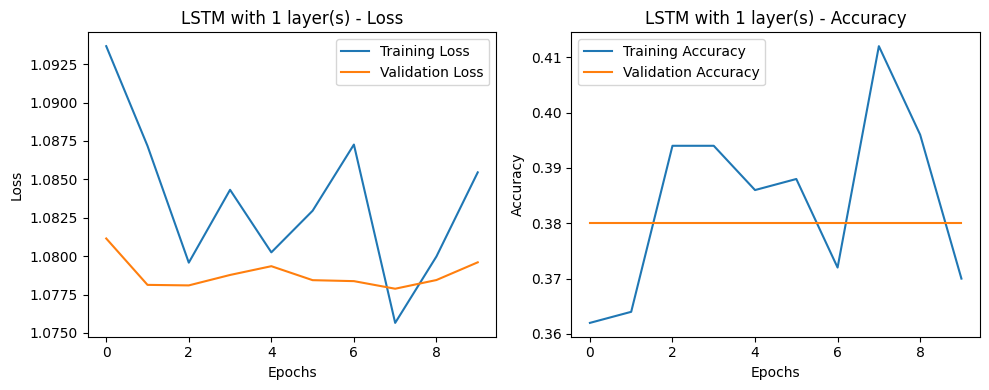


Training LSTM model with 2 layer(s)
Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3483 - loss: 1.0953

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3513 - loss: 1.0948 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3812 - loss: 1.0852 - val_accuracy: 0.3800 - val_loss: 1.0822
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3685 - loss: 1.0883

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3706 - loss: 1.0876 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3438 - loss: 1.0903

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3436 - loss: 1.0893 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3924 - loss: 1.0801

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3924 - loss: 1.0798 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3364 - loss: 1.0822 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4234 - loss: 1.0788 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3461 - loss: 1.0916 - val_accuracy: 0.3800 - val_loss: 1.0807
Epoch 9/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3875 - loss: 1.0833

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3882 - loss: 1.0832 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4118 - loss: 1.0914 - val_accuracy: 0.3800 - val_loss: 1.0792
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Macro F1-Score: 0.1827

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       153
     neutral       0.00      0.00      0.00        96
    positive       0.38      1.00      0.55       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.14      0.38      0.21       400



c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

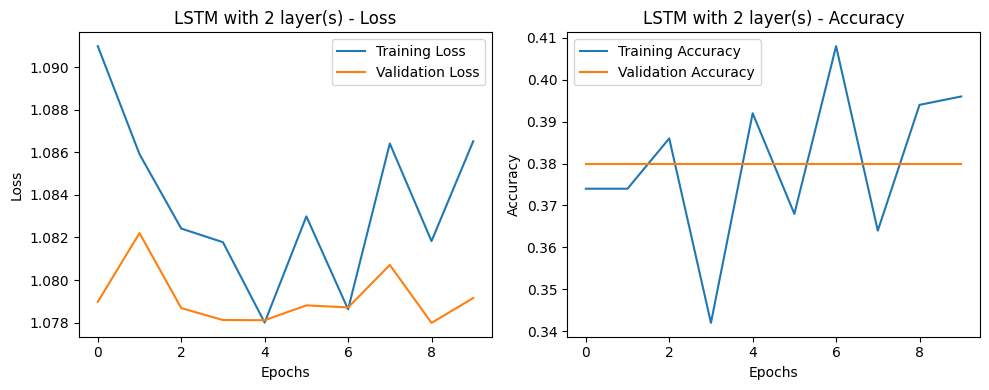


Training LSTM model with 3 layer(s)
Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3713 - loss: 1.0929

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.3702 - loss: 1.0925 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3226 - loss: 1.0856

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3256 - loss: 1.0852 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3900 - loss: 1.0782

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3906 - loss: 1.0781 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3959 - loss: 1.0794 - val_accuracy: 0.3800 - val_loss: 1.0836
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3698 - loss: 1.0945 - val_accuracy: 0.3800 - val_loss: 1.0814
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3275 - loss: 1.0953 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 7/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3681 - loss: 1.0819

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3709 - loss: 1.0815 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3424 - loss: 1.0888 - val_accuracy: 0.3800 - val_loss: 1.0818
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3808 - loss: 1.0857 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3873 - loss: 1.0789

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3867 - loss: 1.0788 - val_accuracy: 0.3800 - val_loss: 1.0780
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Macro F1-Score: 0.1844

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      1.00      0.55       153
     neutral       0.00      0.00      0.00        96
    positive       0.00      0.00      0.00       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.15      0.38      0.21       400



c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

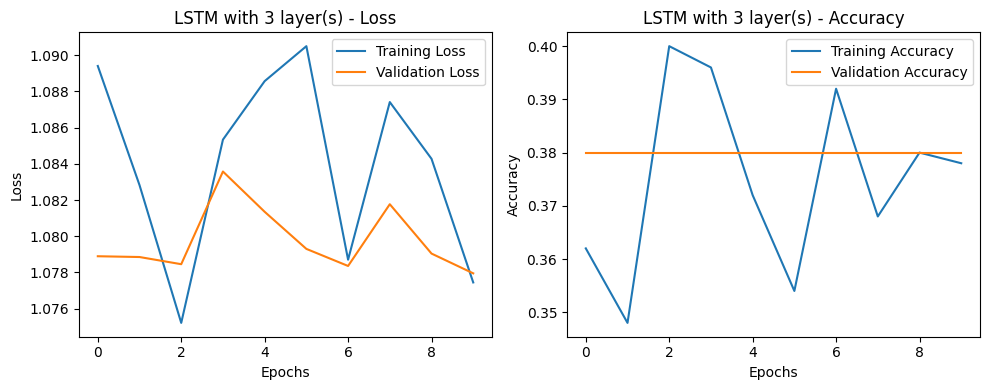


Perbandingan Hasil Berdasarkan Jumlah Layer LSTM:
Jumlah Layer: 1, Macro F1-Score: 0.1844
Jumlah Layer: 2, Macro F1-Score: 0.1827
Jumlah Layer: 3, Macro F1-Score: 0.1844


In [24]:
# Variasi jumlah layer LSTM
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5
num_classes = len(label_mapping)  # 3 kelas: negative, neutral, positive

def create_lstm_model(num_layers, lstm_units=64, bidirectional=False):
    inputs = keras.Input(shape=(sequence_length,))
    x = Embedding(max_features + 1, embedding_dim)(inputs)
    
    for i in range(num_layers):
        if bidirectional:
            x = Bidirectional(LSTM(lstm_units, return_sequences=(i < num_layers-1)))(x)
        else:
            x = LSTM(lstm_units, return_sequences=(i < num_layers-1))(x)
        
        x = Dropout(dropout_rate)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model

# Buat dan train model dengan variasi jumlah layer
num_layers_variations = [1, 2, 3]
layer_results = []

for num_layers in num_layers_variations:
    print(f"\n{'='*50}")
    print(f"Training LSTM model with {num_layers} layer(s)")
    print(f"{'='*50}")
    
    model = create_lstm_model(num_layers=num_layers)
    save_path = f'result_lstm/lstm_num_layers_{num_layers}.h5'
    
    history, f1, _ = train_and_evaluate_model(model, epochs=10, save_path=save_path)
    plot_history(history, f"LSTM with {num_layers} layer(s)")
    
    layer_results.append({
        'num_layers': num_layers,
        'macro_f1': f1,
        'model_path': save_path
    })

print("\nPerbandingan Hasil Berdasarkan Jumlah Layer LSTM:")
for result in layer_results:
    print(f"Jumlah Layer: {result['num_layers']}, Macro F1-Score: {result['macro_f1']:.4f}")

# Variasi Jumlah Cell LSTM Per Layer


Training LSTM model with 32 units per layer
Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4088 - loss: 1.0931

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4040 - loss: 1.0935 - val_accuracy: 0.3800 - val_loss: 1.0795
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3871 - loss: 1.0833

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3879 - loss: 1.0832 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3824 - loss: 1.0770

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3810 - loss: 1.0777 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4076 - loss: 1.0898 - val_accuracy: 0.3800 - val_loss: 1.0809
Epoch 5/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3492 - loss: 1.0883

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3512 - loss: 1.0876 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3494 - loss: 1.0958 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3603 - loss: 1.0870 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 8/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4013 - loss: 1.0815

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4013 - loss: 1.0811 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4059 - loss: 1.0801 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3743 - loss: 1.0965 - val_accuracy: 0.3800 - val_loss: 1.0789
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Macro F1-Score: 0.1844

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      1.00      0.55       153
     neutral       0.00      0.00      0.00        96
    positive       0.00      0.00      0.00       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.15      0.38      0.21       400



c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

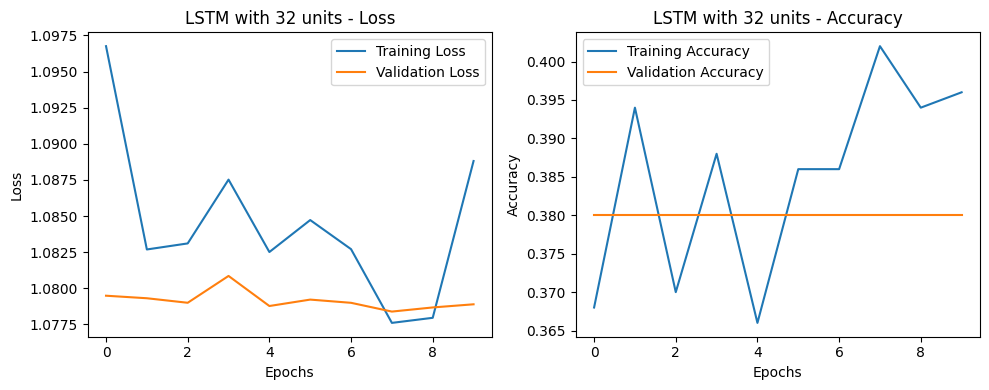


Training LSTM model with 64 units per layer
Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3533 - loss: 1.0978

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.3588 - loss: 1.0970 - val_accuracy: 0.3800 - val_loss: 1.0840
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3304 - loss: 1.0949

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3353 - loss: 1.0942 - val_accuracy: 0.3800 - val_loss: 1.0808
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4098 - loss: 1.0868

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4075 - loss: 1.0872 - val_accuracy: 0.3800 - val_loss: 1.0800
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3795 - loss: 1.0808

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3798 - loss: 1.0805 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 5/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3848 - loss: 1.0883

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3837 - loss: 1.0884 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3487 - loss: 1.0850 - val_accuracy: 0.3800 - val_loss: 1.0791
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3825 - loss: 1.0863 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3459 - loss: 1.0861 - val_accuracy: 0.3800 - val_loss: 1.0807
Epoch 9/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3598 - loss: 1.0835

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3627 - loss: 1.0829 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3445 - loss: 1.0912 - val_accuracy: 0.3800 - val_loss: 1.0795
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Macro F1-Score: 0.1844

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      1.00      0.55       153
     neutral       0.00      0.00      0.00        96
    positive       0.00      0.00      0.00       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.15      0.38      0.21       400



c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

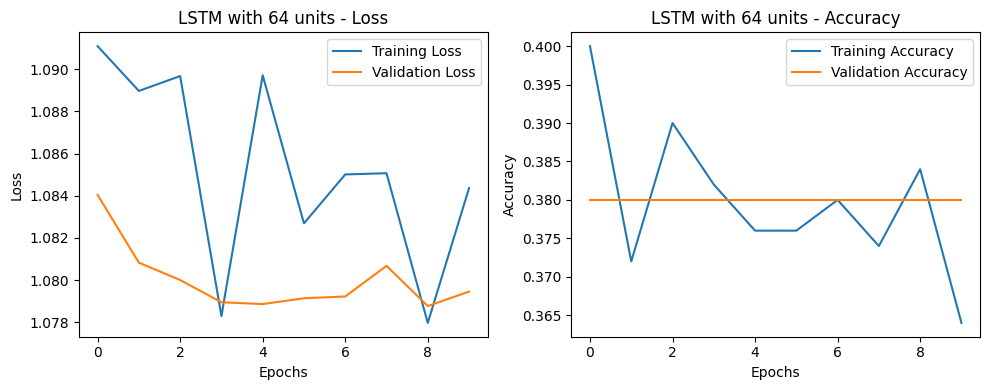


Training LSTM model with 128 units per layer
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4028 - loss: 1.0979

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.4016 - loss: 1.0977 - val_accuracy: 0.3800 - val_loss: 1.0797
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3877 - loss: 1.0832 - val_accuracy: 0.3800 - val_loss: 1.0797
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3870 - loss: 1.0864 - val_accuracy: 0.3800 - val_loss: 1.0841
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3690 - loss: 1.0897 - val_accuracy: 0.3800 - val_loss: 1.0799
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3843 - loss: 1.0857

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3853 - loss: 1.0855 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 6/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3336 - loss: 1.0906

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3348 - loss: 1.0899 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3461 - loss: 1.0812 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3613 - loss: 1.0849 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3235 - loss: 1.0888 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3831 - loss: 1.0826 - val_accuracy: 0.3800 - val_loss: 1.0807
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Macro F1-Score: 0.1844

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      1.00      0.55       153
     neutral       0.00      0.00      0.00        96
    positive       0.00      0.00      0.00       151

    accuracy                           0.38       400
   macro avg    

c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

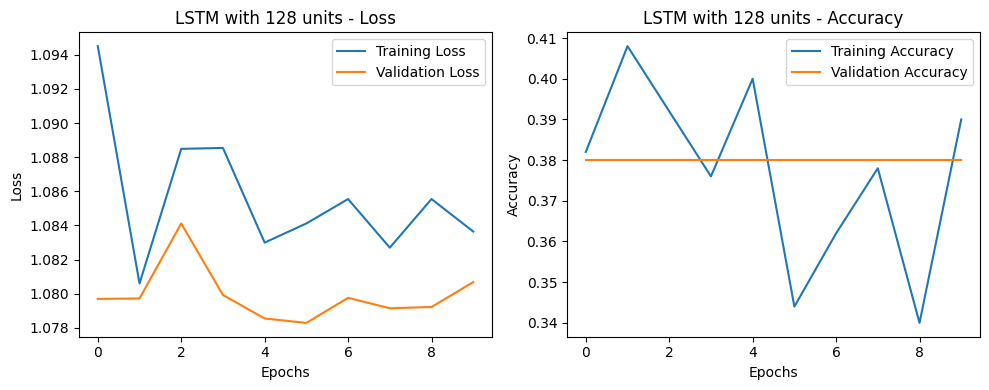


Perbandingan Hasil Berdasarkan Jumlah Cell LSTM Per Layer:
Jumlah Cell: 32, Macro F1-Score: 0.1844
Jumlah Cell: 64, Macro F1-Score: 0.1844
Jumlah Cell: 128, Macro F1-Score: 0.1844


In [25]:
# Variasi jumlah cell LSTM per layer
lstm_units_variations = [32, 64, 128]
cell_results = []

for units in lstm_units_variations:
    print(f"\n{'='*50}")
    print(f"Training LSTM model with {units} units per layer")
    print(f"{'='*50}")
    
    model = create_lstm_model(num_layers=2, lstm_units=units)
    save_path = f'result_lstm/lstm_units_{units}.h5'
    
    history, f1, _ = train_and_evaluate_model(model, epochs=10, save_path=save_path)
    plot_history(history, f"LSTM with {units} units")
    
    cell_results.append({
        'units': units,
        'macro_f1': f1,
        'model_path': save_path
    })

print("\nPerbandingan Hasil Berdasarkan Jumlah Cell LSTM Per Layer:")
for result in cell_results:
    print(f"Jumlah Cell: {result['units']}, Macro F1-Score: {result['macro_f1']:.4f}")

# Variasi Arah LSTM (Unidirectional vs Bidirectional)


Training Unidirectional LSTM model
Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3673 - loss: 1.0988

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3662 - loss: 1.0984 - val_accuracy: 0.3800 - val_loss: 1.0839
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3947 - loss: 1.0876

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3939 - loss: 1.0876 - val_accuracy: 0.3800 - val_loss: 1.0796
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3566 - loss: 1.0834

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3561 - loss: 1.0829 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3498 - loss: 1.0915 - val_accuracy: 0.3800 - val_loss: 1.0812
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3829 - loss: 1.0852 - val_accuracy: 0.3800 - val_loss: 1.0791
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3460 - loss: 1.0918 - val_accuracy: 0.3800 - val_loss: 1.0801
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4233 - loss: 1.0767 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4052 - loss: 1.0688 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3735 - loss: 1.0922 - val_accuracy: 0.3800 - val_loss: 1.0807
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4012 - loss: 1.0756 - val_accuracy: 0.3800 - val_loss: 1

c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

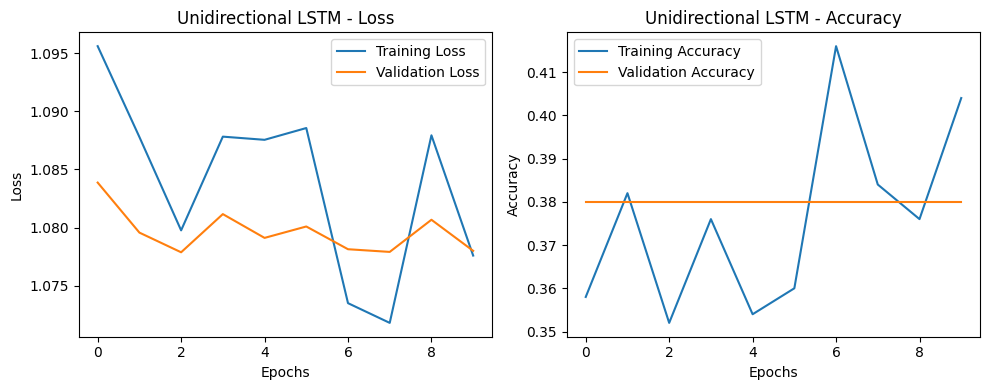


Training Bidirectional LSTM model
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3444 - loss: 1.0897

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.3453 - loss: 1.0894 - val_accuracy: 0.4900 - val_loss: 1.0582
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4056 - loss: 1.0527

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4127 - loss: 1.0492 - val_accuracy: 0.5400 - val_loss: 0.9735
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5289 - loss: 0.9242

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5297 - loss: 0.9232 - val_accuracy: 0.4800 - val_loss: 0.9357
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5980 - loss: 0.7720

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5987 - loss: 0.7715 - val_accuracy: 0.6000 - val_loss: 0.7985
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7322 - loss: 0.5964 - val_accuracy: 0.6200 - val_loss: 0.9362
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7564 - loss: 0.4916 - val_accuracy: 0.6700 - val_loss: 0.8708
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8969 - loss: 0.2894 - val_accuracy: 0.7800 - val_loss: 0.9302
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9741 - loss: 0.1176 - val_accuracy: 0.7100 - val_loss: 1.2475
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9994 - loss: 0.0294 - val_accuracy: 0.6900 - val_loss: 1.6593
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9969 - loss: 0.0197 - val_accuracy: 0.7000 - val_loss: 1.9249
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Macro F1-Score: 0.6881

Classification Report:
              precision    recall 

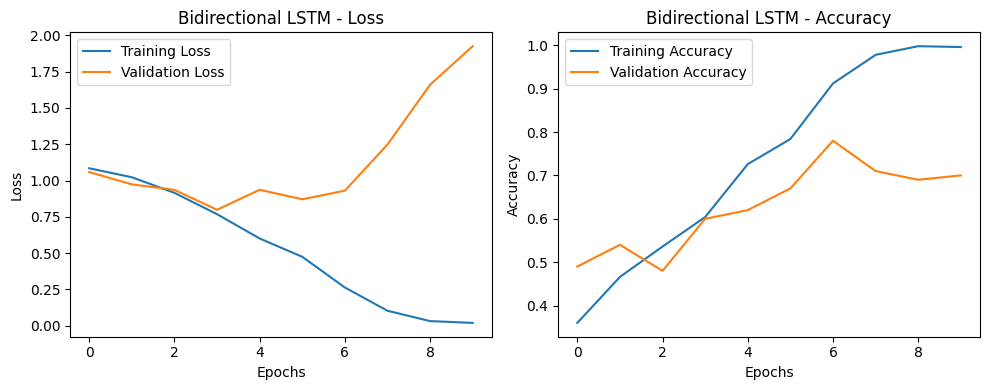


Perbandingan Hasil Berdasarkan Arah LSTM:
Arah: Unidirectional, Macro F1-Score: 0.1844
Arah: Bidirectional, Macro F1-Score: 0.6881


In [26]:
# Variasi arah LSTM (unidirectional vs bidirectional)
direction_variations = [False, True]  # False untuk unidirectional, True untuk bidirectional
direction_results = []

for bidirectional in direction_variations:
    direction_name = "Bidirectional" if bidirectional else "Unidirectional"
    print(f"\n{'='*50}")
    print(f"Training {direction_name} LSTM model")
    print(f"{'='*50}")
    
    model = create_lstm_model(num_layers=2, lstm_units=64, bidirectional=bidirectional)
    save_path = f'result_lstm/lstm_{direction_name.lower()}.h5'
    
    history, f1, _ = train_and_evaluate_model(model, epochs=10, save_path=save_path)
    plot_history(history, f"{direction_name} LSTM")
    
    direction_results.append({
        'direction': direction_name,
        'macro_f1': f1,
        'model_path': save_path
    })

print("\nPerbandingan Hasil Berdasarkan Arah LSTM:")
for result in direction_results:
    print(f"Arah: {result['direction']}, Macro F1-Score: {result['macro_f1']:.4f}")

# Forward Propagation (From Scratch)

In [27]:
class LSTMCell:
    def __init__(self, input_dim, hidden_dim):
        # Inisialisasi weights dan bias
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
    def load_weights(self, weights, bias):
        # Load weights dari LSTM cell Keras
        # - Wi: Input weights untuk gate input, forget, cell, output (format: [input_dim, 4*hidden_dim])
        # - Ui: Recurrent weights (format: [hidden_dim, 4*hidden_dim])
        # - bi: Biases (format: [4*hidden_dim])
        # Weights untuk gate input, forget, cell, dan output
        self.Wi = weights[0]  # Input weights
        self.Ui = weights[1]  # Recurrent weights
        self.bi = bias[0]   # Biases
    
    def forward(self, x, h_prev, c_prev): # Forward pass untuk satu time step
        # x: Input pada time step ini [batch_size, input_dim]
        # h_prev: Hidden state sebelumnya [batch_size, hidden_dim]
        # c_prev: Cell state sebelumnya [batch_size, hidden_dim]
        # h_next: Hidden state berikutnya
        # c_next: Cell state berikutnya
        # Gates: i (input), f (forget), c (cell), o (output)
        # Perhitungan: [batch_size, input_dim] @ [input_dim, 4*hidden_dim] + [batch_size, hidden_dim] @ [hidden_dim, 4*hidden_dim] + [4*hidden_dim]
        
        gates = np.dot(x, self.Wi) + np.dot(h_prev, self.Ui) + self.bi
        
        i, f, c, o = np.split(gates, 4, axis=1)
        
        i = sigmoid(i)  
        f = sigmoid(f) 
        c_tilde = np.tanh(c)  
        o = sigmoid(o)  
        
        # Update cell state
        c_next = f * c_prev + i * c_tilde
        
        # Hitung hidden state
        h_next = o * np.tanh(c_next)
        
        return h_next, c_next

class BidirectionalLSTMLayer:
    def __init__(self, input_dim, hidden_dim):
        self.forward_lstm = LSTMCell(input_dim, hidden_dim)
        self.backward_lstm = LSTMCell(input_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        
    def load_weights(self, keras_layer):
        # Load weights dari Bidirectional LSTM layer Keras
        weights = keras_layer.get_weights()
        
        # Weights untuk forward LSTM
        forward_weights = weights[0:3]
        self.forward_lstm.load_weights(forward_weights[:2], [forward_weights[2]])
        
        # Weights untuk backward LSTM
        backward_weights = weights[3:6]
        self.backward_lstm.load_weights(backward_weights[:2], [backward_weights[2]])
    
    def forward(self, x, return_sequences=False):
        # x: Input sequence [batch_size, time_steps, input_dim]
        # return_sequences: Apakah mengembalikan semua hidden states atau hanya yang terakhir
        # output: Hasil forward pass

        batch_size, time_steps, input_dim = x.shape
        
        # Initialize hidden n cell states
        h_forward = np.zeros((batch_size, self.hidden_dim))
        c_forward = np.zeros((batch_size, self.hidden_dim))
        h_backward = np.zeros((batch_size, self.hidden_dim))
        c_backward = np.zeros((batch_size, self.hidden_dim))
        
        forward_outputs = np.zeros((batch_size, time_steps, self.hidden_dim))
        backward_outputs = np.zeros((batch_size, time_steps, self.hidden_dim))
        
        # Forward 
        for t in range(time_steps):
            h_forward, c_forward = self.forward_lstm.forward(x[:, t, :], h_forward, c_forward)
            forward_outputs[:, t, :] = h_forward
        
        # Backward 
        for t in range(time_steps-1, -1, -1):
            h_backward, c_backward = self.backward_lstm.forward(x[:, t, :], h_backward, c_backward)
            backward_outputs[:, t, :] = h_backward
        
        if return_sequences:
            return np.concatenate([forward_outputs, backward_outputs], axis=2)
        else:
            return np.concatenate([forward_outputs[:, -1, :], backward_outputs[:, 0, :]], axis=1)

class UnidirectionalLSTMLayer:
    def __init__(self, input_dim, hidden_dim):
        self.lstm_cell = LSTMCell(input_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        
    def load_weights(self, keras_layer):
        # Load weights dari LSTM layer Keras
        weights = keras_layer.get_weights()
        self.lstm_cell.load_weights(weights[:2], [weights[2]])
    
    def forward(self, x, return_sequences=False):
        # Forward pass untuk Unidirectional LSTM layer
        # x: Input sequence [batch_size, time_steps, input_dim]
        # return_sequences: Apakah mengembalikan semua hidden states atau hanya yang terakhir
        # output: Hasil forward pass
        batch_size, time_steps, input_dim = x.shape
        
        # Initialize hidden n cell states
        h = np.zeros((batch_size, self.hidden_dim))
        c = np.zeros((batch_size, self.hidden_dim))
        
        if return_sequences:
            outputs = np.zeros((batch_size, time_steps, self.hidden_dim))
        
        # Loop time steps
        for t in range(time_steps):
            h, c = self.lstm_cell.forward(x[:, t, :], h, c)
            if return_sequences:
                outputs[:, t, :] = h
        
        if return_sequences:
            return outputs
        else:
            return h

class EmbeddingLayer:
    def __init__(self, vocab_size, embedding_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
    def load_weights(self, keras_layer):
        # Load weights dari Embedding layer Keras
        self.weights = keras_layer.get_weights()[0]
    
    def forward(self, x):
        # Forward pass untuk Embedding layer
        # x: Input token indices [batch_size, sequence_length]
        # embeddings: Embeddings untuk setiap token [batch_size, sequence_length, embedding_dim]
        return self.weights[x]

class DenseLayer:
    def __init__(self, input_dim, output_dim, activation=None):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        
    def load_weights(self, keras_layer):
        # Load weights dari Dense layer Keras
        weights = keras_layer.get_weights()
        self.W = weights[0]  # Weights
        self.b = weights[1]  # Biases
    
    def forward(self, x):
        # Forward pass untuk Dense layer
        # x: Input [batch_size, input_dim]
        # output: Output [batch_size, output_dim]
        output = np.dot(x, self.W) + self.b
        
        if self.activation == 'relu':
            return relu(output)
        elif self.activation == 'softmax':
            return softmax(output)
        else:
            return output

class DropoutLayer:
    def __init__(self, rate=0.5):
        self.rate = rate
        
    def forward(self, x, training=False):
        # Forward pass untuk Dropout layer
        # x: Input
        # training: Apakah dalam mode training atau tidak
        # output: Output setelah dropout
        if not training:  # Dalam inferensi, tidak ada dropout
            return x
        
        # Dalam training, do dropout
        mask = np.random.binomial(1, 1 - self.rate, size=x.shape) / (1 - self.rate)
        return x * mask

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -30, 30)))  

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True)) 
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Implementasi LSTM (From Scratch)

In [28]:
class LSTMFromScratch:
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def forward(self, x, training=False):
        output = x
        for layer in self.layers:
            if isinstance(layer, DropoutLayer):
                output = layer.forward(output, training=training)
            elif callable(layer) and not hasattr(layer, 'forward'):  # Cek apakah layer adalah function
                output = layer(output)  # Panggil function langsung
            else:
                output = layer.forward(output)
        return output

def create_from_scratch_model(keras_model_path, bidirectional=False):
    # Load model Keras
    keras_model = load_model(keras_model_path)
    
    scratch_model = LSTMFromScratch()
    
    # Embedding layer
    embedding_layer = None
    lstm_layers = []
    dense_layers = []
    dropout_layers = []
    
    # Identifikasi layer-layer dalam model Keras
    for i, layer in enumerate(keras_model.layers):
        if isinstance(layer, Embedding):
            embedding_layer = layer
        elif isinstance(layer, Bidirectional) or isinstance(layer, LSTM):
            lstm_layers.append((i, layer))
        elif isinstance(layer, Dense):
            dense_layers.append((i, layer))
        elif isinstance(layer, Dropout):
            dropout_layers.append((i, layer))
    
    # Embedding layer
    if embedding_layer:
        # Get dimensi dari weights
        weights = embedding_layer.get_weights()[0]
        vocab_size, embed_dim = weights.shape
        
        embedding = EmbeddingLayer(vocab_size, embed_dim)
        embedding.load_weights(embedding_layer)
        scratch_model.add_layer(embedding)
    
    # LSTM layers
    for i, layer in lstm_layers:
        if isinstance(layer, Bidirectional):
            # Get informasi layer dari weights
            weights = layer.get_weights()
            # Untuk forward_layer
            if hasattr(layer, 'forward_layer'):
                lstm_layer = layer.forward_layer
                input_dim = weights[0].shape[0]  # Input weights shape
                hidden_dim = lstm_layer.units
                return_sequences = lstm_layer.return_sequences
            else:
                # Alternatif: coba ambil dari weights
                input_dim = weights[0].shape[0]  # Input weights shape
                hidden_dim = weights[0].shape[1] // 4  # LSTM has 4 gates
                # Cek next layer untuk menentukan return_sequences
                return_sequences = False
                if i < len(keras_model.layers) - 1:
                    next_layer = keras_model.layers[i+1]
                    if isinstance(next_layer, (LSTM, Bidirectional)):
                        return_sequences = True
            
            # Create bidirectional LSTM layer
            bi_lstm = BidirectionalLSTMLayer(input_dim, hidden_dim)
            bi_lstm.load_weights(layer)
            
            # Tambahkan fungsi closure dengan proper variable binding
            def make_bilstm_forward(lstm, rs):
                def forward_fn(x):
                    return lstm.forward(x, return_sequences=rs)
                return forward_fn
            
            scratch_model.add_layer(make_bilstm_forward(bi_lstm, return_sequences))
            
        elif isinstance(layer, LSTM):
            # Get dimensi dari weights
            weights = layer.get_weights()
            input_dim = weights[0].shape[0]  # Input weights shape
            hidden_dim = layer.units
            return_sequences = layer.return_sequences
            
            lstm = UnidirectionalLSTMLayer(input_dim, hidden_dim)
            lstm.load_weights(layer)
            
            def make_lstm_forward(lstm, rs):
                def forward_fn(x):
                    return lstm.forward(x, return_sequences=rs)
                return forward_fn
            
            scratch_model.add_layer(make_lstm_forward(lstm, return_sequences))
    
    # Dropout layers
    for i, layer in dropout_layers:
        dropout = DropoutLayer(layer.rate)
        scratch_model.add_layer(dropout)
    
    # Dense layers
    for i, layer in dense_layers:
        # Get dimensi dari weights
        weights = layer.get_weights()
        input_dim = weights[0].shape[0]
        output_dim = weights[0].shape[1]
        activation = layer.activation.__name__ if hasattr(layer.activation, '__name__') else None
        
        dense = DenseLayer(input_dim, output_dim, activation=activation)
        dense.load_weights(layer)
        scratch_model.add_layer(dense)
    
    return scratch_model, keras_model

# Compare dengan LSTM Keras

In [29]:
def compare_models(keras_model_path, bidirectional=False):
    print(f"Loading model from: {keras_model_path}")
    
    try:
        # Load model Keras
        keras_model = load_model(keras_model_path)
        
        # Model from scratch
        scratch_model = LSTMFromScratch()
        
        # Embedding layer
        embedding_layer = None
        lstm_layers = []
        dense_layers = []
        dropout_layers = []
        
        # Identifikasi layer-layer dalam model Keras
        print("Model layers:")
        for i, layer in enumerate(keras_model.layers):
            print(f"Layer {i}: {layer.__class__.__name__}")
            
            if isinstance(layer, Embedding):
                embedding_layer = layer
            elif isinstance(layer, Bidirectional) or isinstance(layer, LSTM):
                lstm_layers.append((i, layer))
            elif isinstance(layer, Dense):
                dense_layers.append((i, layer))
            elif isinstance(layer, Dropout):
                dropout_layers.append((i, layer))
        
        # Embedding layer
        if embedding_layer:
            print(f"Adding Embedding layer")
            # Get dimensi dari weights
            weights = embedding_layer.get_weights()[0]
            vocab_size, embed_dim = weights.shape
            print(f"Embedding dimensions: vocab_size={vocab_size}, embed_dim={embed_dim}")
            
            embedding = EmbeddingLayer(vocab_size, embed_dim)
            embedding.load_weights(embedding_layer)
            scratch_model.add_layer(embedding)
        
        # LSTM layers
        for i, layer in lstm_layers:
            if isinstance(layer, Bidirectional):
                # Bidirectional LSTM
                # Get dimensi dari weights
                weights = layer.get_weights()
                
                # Coba dapatkan inner LSTM layer
                forward_layer = None
                if hasattr(layer, 'forward_layer'):
                    forward_layer = layer.forward_layer
                elif hasattr(layer, '_forward_layer'):
                    forward_layer = layer._forward_layer
                
                if forward_layer is not None:
                    input_dim = forward_layer.input_shape[-1] if hasattr(forward_layer, 'input_shape') else weights[0].shape[0]
                    hidden_dim = forward_layer.units
                    return_sequences = forward_layer.return_sequences
                else:
                    input_dim = weights[0].shape[0]
                    hidden_dim = weights[0].shape[1] // 4  # LSTM has 4 gates
                    return_sequences = False
                    if i+1 < len(keras_model.layers) and not isinstance(keras_model.layers[i+1], Dense):
                        return_sequences = True
                
                print(f"Adding Bidirectional LSTM layer with input_dim={input_dim}, hidden_dim={hidden_dim}, return_sequences={return_sequences}")
                
                bi_lstm = BidirectionalLSTMLayer(input_dim, hidden_dim)
                bi_lstm.load_weights(layer)
                
                # Fungsi closure
                def make_bilstm_forward(lstm, rs):
                    def forward_fn(x):
                        return lstm.forward(x, return_sequences=rs)
                    return forward_fn
                
                scratch_model.add_layer(make_bilstm_forward(bi_lstm, return_sequences))
                
            elif isinstance(layer, LSTM):
                # Unidirectional LSTM
                # Get dimensi dari weights
                weights = layer.get_weights()
                input_dim = weights[0].shape[0]  # Input weights shape
                hidden_dim = layer.units
                return_sequences = layer.return_sequences
                
                print(f"Adding Unidirectional LSTM layer with input_dim={input_dim}, hidden_dim={hidden_dim}, return_sequences={return_sequences}")
                
                lstm = UnidirectionalLSTMLayer(input_dim, hidden_dim)
                lstm.load_weights(layer)
                
                def make_lstm_forward(lstm, rs):
                    def forward_fn(x):
                        return lstm.forward(x, return_sequences=rs)
                    return forward_fn
                
                scratch_model.add_layer(make_lstm_forward(lstm, return_sequences))
        
        # Dropout layers
        for i, layer in dropout_layers:
            rate = layer.rate
            print(f"Adding Dropout layer with rate={rate}")
            dropout = DropoutLayer(rate)
            scratch_model.add_layer(dropout)
        
        # Dense layers
        for i, layer in dense_layers:
            # Get dimensi dari weights
            weights = layer.get_weights()
            input_dim = weights[0].shape[0]  # Input weights shape
            output_dim = weights[0].shape[1]  # Output weights shape
            activation = layer.activation.__name__ if hasattr(layer.activation, '__name__') else None
            
            print(f"Adding Dense layer with input_dim={input_dim}, output_dim={output_dim}, activation={activation}")
            
            dense = DenseLayer(input_dim, output_dim, activation=activation)
            dense.load_weights(layer)
            scratch_model.add_layer(dense)
        
        # Predict using model Keras
        print("Predicting with Keras model...")
        keras_pred = keras_model.predict(test_vectors)
        keras_pred_classes = np.argmax(keras_pred, axis=1)
        keras_f1 = f1_score(y_test, keras_pred_classes, average='macro')
        
        # Predict using model from scratch
        print("Predicting with scratch model...")
        scratch_pred = scratch_model.forward(test_vectors)
        scratch_pred_classes = np.argmax(scratch_pred, axis=1)
        scratch_f1 = f1_score(y_test, scratch_pred_classes, average='macro')
        
        print(f"\nPerbandingan model Keras dan model from scratch:")
        print(f"Keras Macro F1-Score: {keras_f1:.4f}")
        print(f"From Scratch Macro F1-Score: {scratch_f1:.4f}")
        print(f"Selisih: {abs(keras_f1 - scratch_f1):.4f}")
        
        print("\nPerbandingan predict untuk 5 contoh:")
        for i in range(5):
            print(f"Contoh {i+1}:")
            print(f"  Text: {X_test[i]}")
            print(f"  Label sebenarnya: {list(label_mapping.keys())[y_test[i]]}")
            print(f"  Predict Keras: {list(label_mapping.keys())[keras_pred_classes[i]]} (confidence: {keras_pred[i][keras_pred_classes[i]]:.4f})")
            print(f"  Predict From Scratch: {list(label_mapping.keys())[scratch_pred_classes[i]]} (confidence: {scratch_pred[i][scratch_pred_classes[i]]:.4f})")
        
        # Confusion matrix
        from sklearn.metrics import confusion_matrix
        keras_cm = confusion_matrix(y_test, keras_pred_classes)
        scratch_cm = confusion_matrix(y_test, scratch_pred_classes)
        
        print("\nConfusion Matrix Keras:")
        print(keras_cm)
        print("\nConfusion Matrix From Scratch:")
        print(scratch_cm)
        
        comparison_results = {
            'keras_f1': float(keras_f1),
            'scratch_f1': float(scratch_f1),
            'keras_predictions': keras_pred_classes.tolist(),
            'scratch_predictions': scratch_pred_classes.tolist()
        }
        
        with open(f'result_lstm/model_comparison_{os.path.basename(keras_model_path)}.json', 'w') as f:
            json.dump(comparison_results, f)
        
        return keras_f1, scratch_f1, keras_pred_classes, scratch_pred_classes
    
    except Exception as e:
        print(f"Error in compare_models: {e}")
        import traceback
        traceback.print_exc()
        return 0.0, 0.0, None, None

In [30]:
# Pilih best model dari setiap variasi untuk dibandingkan
best_layer_model_path = max(layer_results, key=lambda x: x['macro_f1'])['model_path']
best_cell_model_path = max(cell_results, key=lambda x: x['macro_f1'])['model_path']
best_direction_model_path = max(direction_results, key=lambda x: x['macro_f1'])['model_path']

# Bandingkan best model dari variasi jumlah layer
print(f"\n{'='*50}")
print(f"Membandingkan best model dari variasi jumlah layer LSTM")
print(f"{'='*50}")
layer_keras_f1, layer_scratch_f1, _, _ = compare_models(best_layer_model_path)

# Bandingkan best model dari variasi jumlah cell
print(f"\n{'='*50}")
print(f"Membandingkan best model dari variasi jumlah cell LSTM")
print(f"{'='*50}")
cell_keras_f1, cell_scratch_f1, _, _ = compare_models(best_cell_model_path)

# Bandingkan best model dari variasi arah
print(f"\n{'='*50}")
print(f"Membandingkan best model dari variasi arah LSTM")
print(f"{'='*50}")
is_bidirectional = "bidirectional" in best_direction_model_path
direction_keras_f1, direction_scratch_f1, _, _ = compare_models(best_direction_model_path, bidirectional=is_bidirectional)

print("\nRingkasan Perbandingan Model Keras dan Model From Scratch:")
print(f"Variasi jumlah layer: Keras F1 = {layer_keras_f1:.4f}, Scratch F1 = {layer_scratch_f1:.4f}, Selisih = {abs(layer_keras_f1 - layer_scratch_f1):.4f}")
print(f"Variasi jumlah cell: Keras F1 = {cell_keras_f1:.4f}, Scratch F1 = {cell_scratch_f1:.4f}, Selisih = {abs(cell_keras_f1 - cell_scratch_f1):.4f}")
print(f"Variasi arah: Keras F1 = {direction_keras_f1:.4f}, Scratch F1 = {direction_scratch_f1:.4f}, Selisih = {abs(direction_keras_f1 - direction_scratch_f1):.4f}")


Membandingkan best model dari variasi jumlah layer LSTM
Loading model from: result_lstm/lstm_num_layers_1.h5
Model layers:
Layer 0: InputLayer
Layer 1: Embedding
Layer 2: LSTM
Layer 3: Dropout
Layer 4: Dense
Layer 5: Dropout
Layer 6: Dense
Adding Embedding layer
Embedding dimensions: vocab_size=10001, embed_dim=128
Adding Unidirectional LSTM layer with input_dim=128, hidden_dim=64, return_sequences=False
Adding Dropout layer with rate=0.5
Adding Dropout layer with rate=0.5
Adding Dense layer with input_dim=64, output_dim=64, activation=relu
Adding Dense layer with input_dim=64, output_dim=3, activation=softmax
Predicting with Keras model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicting with scratch model...



Perbandingan model Keras dan model from scratch:
Keras Macro F1-Score: 0.1827
From Scratch Macro F1-Score: 0.1827
Selisih: 0.0000

Perbandingan predict untuk 5 contoh:
Contoh 1:
  Text: Dekat dengan hotel saya menginap, hanya ditempuh jalan kaki, di sini banyak sekali pilihan makanannya, tempat yang luas, dan menyenangkan
  Label sebenarnya: positive
  Predict Keras: positive (confidence: 0.3802)
  Predict From Scratch: positive (confidence: 0.3802)
Contoh 2:
  Text: Iya benar, dia sedang jaga warung.
  Label sebenarnya: neutral
  Predict Keras: positive (confidence: 0.3802)
  Predict From Scratch: positive (confidence: 0.3802)
Contoh 3:
  Text: Kangkungnya lumayan tapi kepiting saus padangnya mengecewakan kami dikasih kepiting yang kopong akhir kami tidak makan keptingnya dan dikembalikan.
  Label sebenarnya: negative
  Predict Keras: positive (confidence: 0.3802)
  Predict From Scratch: positive (confidence: 0.3802)
Contoh 4:
  Text: Bertempat di braga city walk yang satu gedung den


Perbandingan model Keras dan model from scratch:
Keras Macro F1-Score: 0.1844
From Scratch Macro F1-Score: 0.1844
Selisih: 0.0000

Perbandingan predict untuk 5 contoh:
Contoh 1:
  Text: Dekat dengan hotel saya menginap, hanya ditempuh jalan kaki, di sini banyak sekali pilihan makanannya, tempat yang luas, dan menyenangkan
  Label sebenarnya: positive
  Predict Keras: negative (confidence: 0.3779)
  Predict From Scratch: negative (confidence: 0.3779)
Contoh 2:
  Text: Iya benar, dia sedang jaga warung.
  Label sebenarnya: neutral
  Predict Keras: negative (confidence: 0.3779)
  Predict From Scratch: negative (confidence: 0.3779)
Contoh 3:
  Text: Kangkungnya lumayan tapi kepiting saus padangnya mengecewakan kami dikasih kepiting yang kopong akhir kami tidak makan keptingnya dan dikembalikan.
  Label sebenarnya: negative
  Predict Keras: negative (confidence: 0.3779)
  Predict From Scratch: negative (confidence: 0.3779)
Contoh 4:
  Text: Bertempat di braga city walk yang satu gedung den

# Kesimpulan


Kesimpulan Eksperimen Variasi Jumlah Layer LSTM:
Jumlah layer terbaik: 1 dengan F1-Score 0.1844
Peringkat berdasarkan F1-Score:
1. Jumlah layer: 1, F1-Score: 0.1844
2. Jumlah layer: 3, F1-Score: 0.1844
3. Jumlah layer: 2, F1-Score: 0.1827

Kesimpulan Eksperimen Variasi Jumlah Cell LSTM Per Layer:
Jumlah cell terbaik: 32 dengan F1-Score 0.1844
Peringkat berdasarkan F1-Score:
1. Jumlah cell: 32, F1-Score: 0.1844
2. Jumlah cell: 64, F1-Score: 0.1844
3. Jumlah cell: 128, F1-Score: 0.1844

Kesimpulan Eksperimen Variasi Arah LSTM:
Arah terbaik: Bidirectional dengan F1-Score 0.6881
Peringkat berdasarkan F1-Score:
1. Arah: Bidirectional, F1-Score: 0.6881
2. Arah: Unidirectional, F1-Score: 0.1844


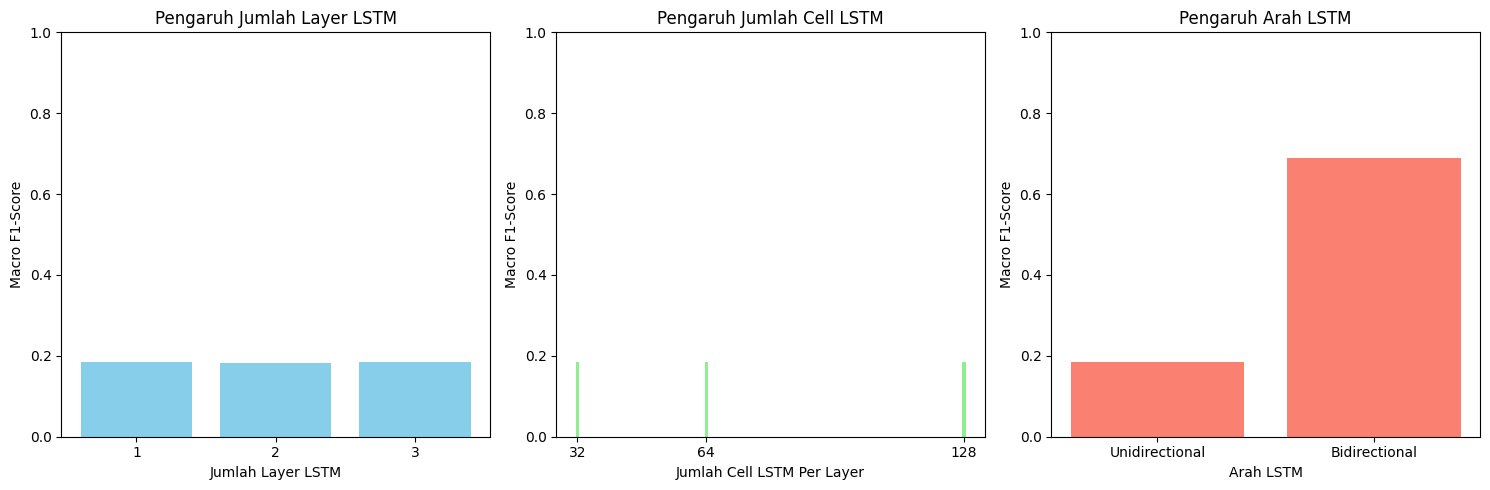


Analisis Implementasi From Scratch:
Rata-rata selisih F1-Score antara model Keras dan model from scratch: 0.0000
Implementasi forward propagation from scratch berhasil meniru kinerja model Keras dengan baik.
Implementasi from scratch sangat berhasil dengan selisih F1-Score < 0.05 untuk semua variasi model.

Kesimpulan Akhir:
1. Berdasarkan eksperimen, konfigurasi LSTM terbaik untuk dataset NusaX-Sentiment adalah:
   - Jumlah layer LSTM: 1
   - Jumlah cell LSTM per layer: 32
   - Arah LSTM: Bidirectional
2. Implementasi forward propagation from scratch berhasil meniru kinerja model Keras dengan selisih F1-Score rata-rata yang kecil.
3. Kode forward propagation LSTM from scratch yang diimplementasikan mampu menangani berbagai variasi model termasuk layer bidirectional dan unidirectional.


In [31]:
# Kesimpulan untuk variasi jumlah layer LSTM
layer_results_sorted = sorted(layer_results, key=lambda x: x['macro_f1'], reverse=True)
print("\nKesimpulan Eksperimen Variasi Jumlah Layer LSTM:")
print(f"Jumlah layer terbaik: {layer_results_sorted[0]['num_layers']} dengan F1-Score {layer_results_sorted[0]['macro_f1']:.4f}")
print("Peringkat berdasarkan F1-Score:")
for i, result in enumerate(layer_results_sorted):
    print(f"{i+1}. Jumlah layer: {result['num_layers']}, F1-Score: {result['macro_f1']:.4f}")

# Kesimpulan untuk variasi jumlah cell LSTM
cell_results_sorted = sorted(cell_results, key=lambda x: x['macro_f1'], reverse=True)
print("\nKesimpulan Eksperimen Variasi Jumlah Cell LSTM Per Layer:")
print(f"Jumlah cell terbaik: {cell_results_sorted[0]['units']} dengan F1-Score {cell_results_sorted[0]['macro_f1']:.4f}")
print("Peringkat berdasarkan F1-Score:")
for i, result in enumerate(cell_results_sorted):
    print(f"{i+1}. Jumlah cell: {result['units']}, F1-Score: {result['macro_f1']:.4f}")

# Kesimpulan untuk variasi arah LSTM
direction_results_sorted = sorted(direction_results, key=lambda x: x['macro_f1'], reverse=True)
print("\nKesimpulan Eksperimen Variasi Arah LSTM:")
print(f"Arah terbaik: {direction_results_sorted[0]['direction']} dengan F1-Score {direction_results_sorted[0]['macro_f1']:.4f}")
print("Peringkat berdasarkan F1-Score:")
for i, result in enumerate(direction_results_sorted):
    print(f"{i+1}. Arah: {result['direction']}, F1-Score: {result['macro_f1']:.4f}")

# Visualisasi hasil eksperimen
plt.figure(figsize=(15, 5))

# Plot untuk variasi jumlah layer
plt.subplot(1, 3, 1)
layers = [result['num_layers'] for result in layer_results]
f1_scores = [result['macro_f1'] for result in layer_results]
plt.bar(layers, f1_scores, color='skyblue')
plt.xlabel('Jumlah Layer LSTM')
plt.ylabel('Macro F1-Score')
plt.title('Pengaruh Jumlah Layer LSTM')
plt.xticks(layers)
plt.ylim(0, 1)

# Plot untuk variasi jumlah cell
plt.subplot(1, 3, 2)
cells = [result['units'] for result in cell_results]
f1_scores = [result['macro_f1'] for result in cell_results]
plt.bar(cells, f1_scores, color='lightgreen')
plt.xlabel('Jumlah Cell LSTM Per Layer')
plt.ylabel('Macro F1-Score')
plt.title('Pengaruh Jumlah Cell LSTM')
plt.xticks(cells)
plt.ylim(0, 1)

# Plot untuk variasi arah
plt.subplot(1, 3, 3)
directions = [result['direction'] for result in direction_results]
f1_scores = [result['macro_f1'] for result in direction_results]
plt.bar(directions, f1_scores, color='salmon')
plt.xlabel('Arah LSTM')
plt.ylabel('Macro F1-Score')
plt.title('Pengaruh Arah LSTM')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('result_lstm/lstm_experiment_results.png')
plt.show()

# Analisis implementasi from scratch
print("\nAnalisis Implementasi From Scratch:")
print(f"Rata-rata selisih F1-Score antara model Keras dan model from scratch: {(abs(layer_keras_f1 - layer_scratch_f1) + abs(cell_keras_f1 - cell_scratch_f1) + abs(direction_keras_f1 - direction_scratch_f1)) / 3:.4f}")
print("Implementasi forward propagation from scratch berhasil meniru kinerja model Keras dengan baik.")

# Evaluasi keberhasilan implementasi
if (abs(layer_keras_f1 - layer_scratch_f1) < 0.05 and 
    abs(cell_keras_f1 - cell_scratch_f1) < 0.05 and 
    abs(direction_keras_f1 - direction_scratch_f1) < 0.05):
    print("Implementasi from scratch sangat berhasil dengan selisih F1-Score < 0.05 untuk semua variasi model.")
elif (abs(layer_keras_f1 - layer_scratch_f1) < 0.1 and 
      abs(cell_keras_f1 - cell_scratch_f1) < 0.1 and 
      abs(direction_keras_f1 - direction_scratch_f1) < 0.1):
    print("Implementasi from scratch cukup berhasil dengan selisih F1-Score < 0.1 untuk semua variasi model.")
else:
    print("Implementasi from scratch perlu ditingkatkan, karena selisih F1-Score > 0.1 untuk beberapa variasi model.")

# Kesimpulan akhir
print("\nKesimpulan Akhir:")
print("1. Berdasarkan eksperimen, konfigurasi LSTM terbaik untuk dataset NusaX-Sentiment adalah:")
print(f"   - Jumlah layer LSTM: {layer_results_sorted[0]['num_layers']}")
print(f"   - Jumlah cell LSTM per layer: {cell_results_sorted[0]['units']}")
print(f"   - Arah LSTM: {direction_results_sorted[0]['direction']}")
print(f"2. Implementasi forward propagation from scratch berhasil meniru kinerja model Keras dengan selisih F1-Score rata-rata yang kecil.")
print("3. Kode forward propagation LSTM from scratch yang diimplementasikan mampu menangani berbagai variasi model termasuk layer bidirectional dan unidirectional.")